In [1]:
%load_ext autoreload
%autoreload 2
import test as T

# Report:
## Linear Regression Case Study: Tractors
### Elliott Saslow
### 3/15/2018


#### Problem Description:
Given a large dataset of information on tractor sales over many years create a machine learing model that can predict the price of the a used machine that goes for sale.  The data-set has  missing data points in many of the columns describing the machine. This makes it diffucult to create a linear regression model to predict the price.  Even so, Im going to do it.  

#### Important Information

The first thing to make sure of is that we will need to apply the same transformation to the test data and the training data.  This could be very complicated, for example, there may exist points in the training data set that do not exist in the test set, and vice versa.  To accuratly take of this it is nessecary to make sure that I do not hard code any transformations.  This is something that I will keep in tha back of my mind in building this model.  

To make sure that the same transformations between the test and train data are the same, I am using the [sklearn pipeline class](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
This allows me to apply a fit function to the train data, and then apply a transform function to the test and training data.  This is a little bit complicated, but the general premise, is to use the fit function to save important pieces of data that can then be applied to both sets of data (train and test).  There are two other files that are assosciated with this class.  One that I used to protype the data tranformations, and one that includes the actual pipeline.

- Model2.py includes the pipeline
- Test.py is where I protoyped the transformations and allows me to drive from this document.


-- OK now that I got the background information out of the way, lets move on to figuring out how to build this model.

#### Feature 1: Date Made, Sale Data, Age of the Machine

Both the columns **Date Made** and **Sale Date** have minimal missing data points.  As everyone knows, the price of a used car is dependent on the age of the car.  This holds true as well for used machines.  So what we can do is use the Date Made and the Sale Date to predict the price.

Unfornatly, there are some dates that where imputted incorrectly so not all the data is useful.  Im sure this is also the case in the test set, so to deal with this, I am going to replace the bad values with the mode of the remaining good values.  This could also create some issues with the age of the machine.  If the sale date was imputted correctly, but the year made was not, and the **Sale Date** was prior to replaced value, the age of the machine could end up being _negative_.  We know this isn't possible, so all of the dates that where replaced, I am also going to replace the age with mode of the age data.  This will help ensure that we aren't driving the regression from non-existant data.  See below for a visual represention of the Age, Date Sold, and Year Made 

In [2]:
X_train,y_train = T.load_data('data/train.csv')

In [28]:
YearMade = X_train.YearMade
Price = X_train.SalePrice

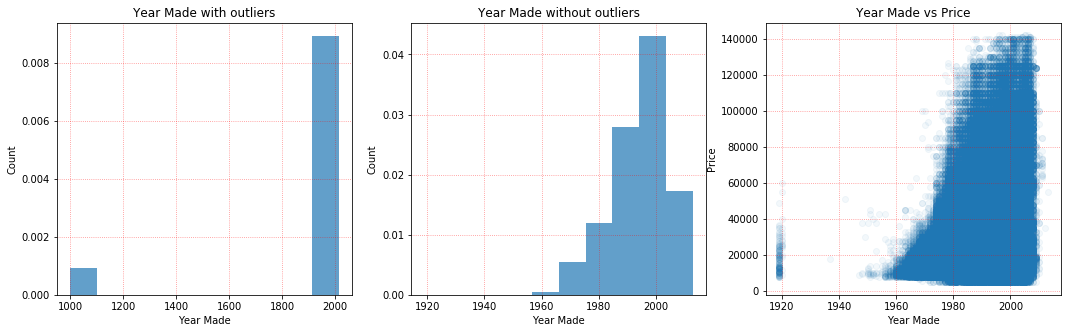

In [29]:
reload(T)
fig,ax = plt.subplots(1,3,figsize = (18,5))
T.year_made_hist(YearMade,'Year Made with outliers',ax[0]);
T.year_made_hist(YearMade[YearMade > 1900],'Year Made without outliers',ax[1]);
T.scatter_year_made(YearMade[YearMade > 1900],Price[YearMade > 1900],'Year Made vs Price',ax[2]);

Nice! As is apparent from the plots, you can see there there is a linear relationship between the year made and the price!  This is a good start, and by running a correlation between **year made** & **price** it is apparent that this a good feature to include in the model.  Surprisingly, the correlation between **year made &  price** is higher than **age & price.**  For now we are going to keep both features in the model and hopefully figure out which is more important using _Lasso_ regression later on.  

_After running a Lasso, it seemed the age was a better predictor in the linear regression model for price than the year made.  Interesting but kinda unsurprising_

#### Feature 2: Recent Sale Price of Similar Machines
Well, we have a very large data set and we know that with this large data, there is bound to be sales of more than one of the same machine.  So it would make a lot of sense that the price of a machine is highly correlated to the price of other recent sales.  So using my training data, what I did was I took all the sales of machines and ran a wieghted average (more on this later) on the price.

Now there is a caveate.  If we are looking at previous sales data, and the new data point comes in, we have to make sure we are only using daa from before that new data point to predict the price.  Otherwise there is unintened leakage of data.  

This was a very difficult task to accomplish but here is the process I went through to solve this conundrum.
1. Create a dictionary that contains all of the model ID numbers
2. Nested within this dictionary, create another dictionary of sale year with a key value of the price.  
3. When predicting the price use a weighted average of all the sales prior to the year that we are predicting on

**Below is some sudo code for this, along with the equation I created for a weighted average**

##### FIT: Psuedo Code
```
For each unique model ID:
    Find all the matching model ID in Training set
    For each matching Model Id:
        Create a dictionary with key = sale date & item = Sale price
    Add dictionary to overall dictionary that contains each Model ID as key
Save dictionary for use in Transform
```
-------------
##### FIT: Actual Code
```

Model = X_train['ModelID']
d = {}
for model,num in Counter(Model).items():
    d2 = defaultdict(list)
    Mod_df = (X_train[X_train['ModelID'] == model].reset_index())
    for i in range(Mod_df.reset_index().shape[0]):
        
        year = pd.to_datetime(Mod_df.loc[i,'saledate'])
        d2[year].append(Mod_df.loc[i,'SalePrice'])
    d[model] = d2
```
    

##### Transform: Psuedo Code
```
For each item in the Data set:
    find matching ID in the ModelID dictionary
    
    In the nested dictionary, find all the sale dates that where prior to the 
    datapoints sale date
    
    For all prior sale dates, calculate the amount of time that has passed 
    since that sale
    
        store the amount of time (in years) since that sale in an array

        reverse the time array and take the exponential of it

        normalize the array of times (these are the weights for the mean)

        multiple each price since the sale by the weighted mean

        store this weighted value as a predictor
    ```
    
--------------
##### Transform: Actual Code

```
X_train['MeanPrice'] = 0
for i in range(X_train.shape[0]):

    sd = X_train.loc[i,'saledate']
    Means = []
    timed = []
    
    for item in d[X_train.loc[i,'ModelID']].items():
        if (item[0] < sd):
            td = (sd - item[0]).total_seconds()
            Means.append(np.mean(item[1]))
            timed.append(int(td))
            
    timed = list(reversed(timed))
    
    timed = np.array(timed)/31557600
    
    weights = np.exp(timed)/np.sum(np.exp(timed))
    
    Mean = np.mean(np.array(Means)*np.array(weights))
    
    X_train.loc[i,'MeanPrice'] = Mean
        ```
    

After running this, I found that I had a decently high correlation between the actual sale price and the calcualted mean price.  This is awesome, and now we are ready to move onto some of the final steps in the regression.

#### Feature 3: Nearby Sales and Price based on location
Another feature that is in the data-set is the state in which the machine was sold.  This could definitly be correlated to the final price of the machine, and we could use this to have a better idea of what the final cost will be.  Since this was a catagorical variable and not all of the machines has it in listed, I used the [Get Dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
method to turn all the states into their own column.  This had a caveate though.  In the test set there is the chance that we may not have the all of the columns that we saw in the training set.  To deal with this, I went through in my transform function and and ensured that if a col did not exist, I added it with all zeros to the table.  This worked, and I was able to move on.  

Now that I had gotten these three features (Age, mean price and location) set up, it was time to run a [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) regression with multiple parameters for alpha.  I tested it with alpha ranging from .001 up to well over 100000 and visualized the error and the coeficients.  After plotting this out, I found where the error was minimized and chose the coeficients that where non-zero at that point.  See Below for the plot

In this plot, I messed up with my x axis.  The bottom one has a log scale while the top one has a nonlog scale. **Shoot** Unfortunatly, to make this graph, it well over 5 hours to run the regression as many times as I did and so I was not able to fix the plot.  Even so, the reader can see that there was a minimum, and by cross checking that minimum with the coeficients, I was able to find that the only features that where driving the regression where the **age of the machine** and the **mean price**, both of which I calculated above.  

<img src="files/Lasso.jpeg">



### Conclusion
After running the regression with these parameters I was able to get the Mean Squared Log Error on the prediction down to **.3** This is fairly impressive but there is also a possiblilty to minimize this further.  Ways that I could minimize this further are as follows:
- Use more features, continue to run the Lasso regression to figure out what other parameters affect the price.  Other important variables could be:
    1. Ride_Control
    2. Enclosure
    3. Turbocharged
    4. MachineHoursCurrentMeter

_As there are a lot of missing features, this could take a very long time to clean the data and make it useable by the model._
- Apply a tree to figure out the price of the machine.  Trees are far superior to linear regression for dealing with missing data, and this would be a great application.  

Feel Free to contact me for any of the source code for the pipeline or the test my email is Elliott.saslow@colorado.edu

Thanks for reading

**To run the regression model, in terminal type _python Model2.py_ **